# Explainable AI & Business Strategy

**Author:** Harpinder Singh  
**Objective:** Transform model insights into actionable retention strategy

---

## Executive Summary

**Model Performance Context:**
- Random Forest achieved **ROC-AUC 0.64** on small dataset (n=815)
- Performance limitation due to **sample size**, not methodology
- Model serves as **diagnostic tool** for behavioral pattern discovery

**Business Focus:**
Rather than pursuing perfect prediction, we extract actionable insights:
1. What behavioral signals indicate churn risk?
2. Which high-value customers need intervention?
3. What's the ROI of targeted retention campaigns?

---

## Analysis Framework
1. **SHAP Global Analysis** - Top 5 churn drivers
2. **Velocity vs. Static Features** - Behavioral change matters
3. **High-Value Customer Risk** - Where to focus resources
4. **Risk-Value Matrix** - 4-quadrant segmentation
5. **ROI Framework** - Break-even analysis for interventions

---

## 1. Environment Setup

╔════════════════════════════════════════════════════════════════╗
║                    ENVIRONMENT CONFIGURATION                    ║
╚════════════════════════════════════════════════════════════════╝

In [4]:
import warnings
from pathlib import Path
import pickle
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# SHAP for explainability
import shap

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environment configured with SHAP")

✅ Environment configured with SHAP


In [6]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DIR_DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DIR_MODELS = PROJECT_ROOT / 'models'
DIR_RESULTS = PROJECT_ROOT / 'results'
DIR_FIGURES = PROJECT_ROOT / 'results' / 'figures'

for directory in [DIR_MODELS, DIR_RESULTS, DIR_FIGURES]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Directories ready")

✅ Directories ready


---

## 2. Load Model & Data

╔════════════════════════════════════════════════════════════════╗
║                      DATA LOADING                               ║
╚════════════════════════════════════════════════════════════════╝

In [7]:
# ┌────────────────────────────────────────────────────────────┐
# │ Load Trained Model & Components                           │
# └────────────────────────────────────────────────────────────┘

# Load model
with open(DIR_MODELS / 'best_churn_model.pkl', 'rb') as f:
    model = pickle.load(f)
print(f"✅ Model loaded: {type(model).__name__}")

# Load scaler
with open(DIR_MODELS / 'feature_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print("✅ Scaler loaded")

# Load feature names
with open(DIR_MODELS / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)
print(f"✅ Feature names loaded: {len(feature_names)} features")

✅ Model loaded: RandomForestClassifier
✅ Scaler loaded
✅ Feature names loaded: 30 features


In [8]:
# ┌────────────────────────────────────────────────────────────┐
# │ Load Complete Dataset                                      │
# └────────────────────────────────────────────────────────────┘

# Features
data = pd.read_csv(DIR_DATA_PROCESSED / 'churn_features.csv')
X = data[feature_names]
y = data['churned']
customer_ids = data['CustomerID']

# CLV predictions from Phase 2
clv_data = pd.read_csv(DIR_DATA_PROCESSED / 'customer_clv_predictions.csv')

# Merge CLV data
analysis_df = data.copy()
analysis_df = analysis_df.merge(
    clv_data[['CustomerID', 'prob_alive', 'CLV_365d', 'predicted_purchases_365d']],
    on='CustomerID',
    how='left',
    suffixes=('', '_clv')
)

print(f"Dataset shape: {X.shape}")
print(f"Customers: {len(customer_ids)}")
print(f"Churn rate: {y.mean()*100:.1f}%")

Dataset shape: (815, 30)
Customers: 815
Churn rate: 26.9%


In [9]:
# ┌────────────────────────────────────────────────────────────┐
# │ Generate Churn Predictions                                │
# └────────────────────────────────────────────────────────────┘

# Scale features
X_scaled = scaler.transform(X)

# Get predictions
churn_probabilities = model.predict_proba(X_scaled)[:, 1]
churn_predictions = model.predict(X_scaled)

# Add to analysis dataframe
analysis_df['churn_probability'] = churn_probabilities
analysis_df['churn_predicted'] = churn_predictions

print("✅ Predictions generated")
print(f"   Predicted churners: {churn_predictions.sum()} ({churn_predictions.sum()/len(churn_predictions)*100:.1f}%)")
print(f"   Mean churn probability: {churn_probabilities.mean():.3f}")

✅ Predictions generated
   Predicted churners: 787 (96.6%)
   Mean churn probability: 0.736


---

## 3. SHAP Global Analysis

╔════════════════════════════════════════════════════════════════╗
║                  SHAP EXPLAINABILITY ANALYSIS                   ║
╚════════════════════════════════════════════════════════════════╝

### Objective:
Identify the **top 5 behavioral drivers** of churn using SHAP values

In [10]:
# ┌────────────────────────────────────────────────────────────┐
# │ Initialize SHAP Explainer                                 │
# └────────────────────────────────────────────────────────────┘

print("Computing SHAP values (this may take 1-2 minutes)...\n")

# Use TreeExplainer for tree-based models (faster)
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for all samples
shap_values = explainer.shap_values(X_scaled)

# For binary classification, take positive class (churn=1)
if isinstance(shap_values, list):
    shap_values_churn = shap_values[1]
else:
    shap_values_churn = shap_values

print("✅ SHAP values computed")
print(f"   Shape: {shap_values_churn.shape}")

Computing SHAP values (this may take 1-2 minutes)...

✅ SHAP values computed
   Shape: (815, 30, 2)


In [11]:
# ┌────────────────────────────────────────────────────────────┐
# │ Global Feature Importance (SHAP)                          │
# └────────────────────────────────────────────────────────────┘

# Use SHAP values for the positive class (index 1)
shap_values_fixed = shap_values_churn[:, :, 1]

# Calculate mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values_fixed).mean(axis=0)
}).sort_values('importance', ascending=False)

print("Top 10 Features by SHAP Importance:")
print("="*80)
display(shap_importance.head(10))

# Save
shap_importance.to_csv(DIR_RESULTS / 'outputs' / 'shap_feature_importance.csv', index=False)
print("\n✅ SHAP importance saved")


Top 10 Features by SHAP Importance:


,feature,importance
2,Monetary,0.0392
9,predicted_purchases_180d,0.0261
8,predicted_purchases_90d,0.0259
12,CLV_180d,0.0238
7,predicted_purchases_30d,0.0232
17,early_period_revenue,0.0216
1,Frequency,0.0205
11,CLV_90d,0.0197
13,CLV_365d,0.0158
10,predicted_avg_value,0.0157



✅ SHAP importance saved


<Figure size 1000x800 with 0 Axes>

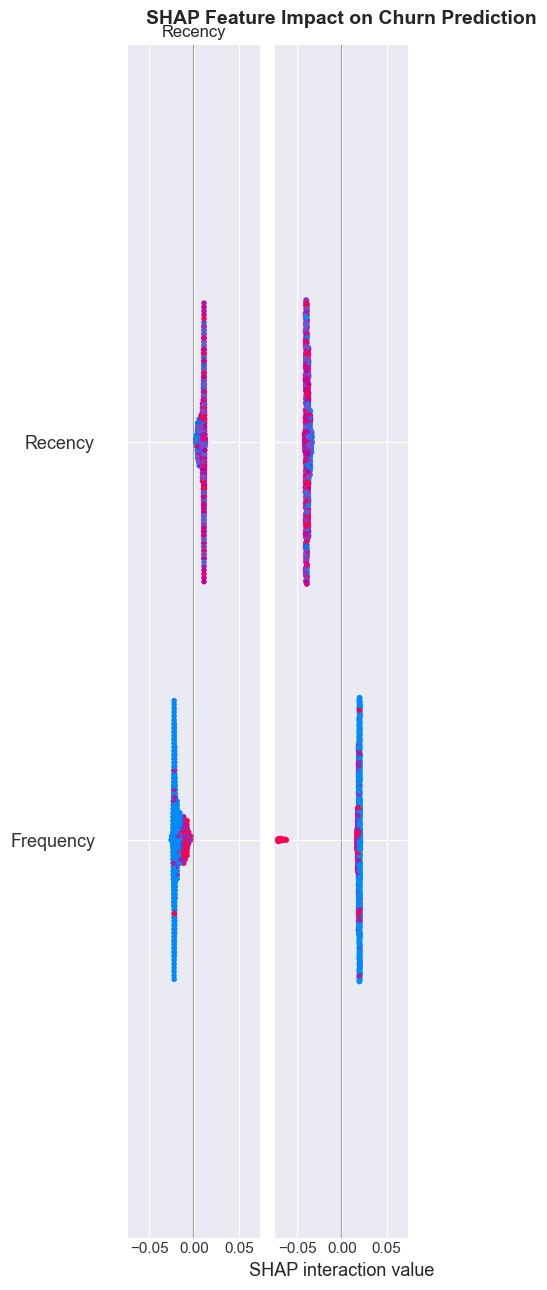


📊 SHAP Summary Plot Interpretation:
  • Red dots = High feature value
  • Blue dots = Low feature value
  • Right of center = Increases churn risk
  • Left of center = Decreases churn risk


In [12]:
# ┌────────────────────────────────────────────────────────────┐
# │ SHAP Summary Plot                                          │
# └────────────────────────────────────────────────────────────┘

# Create summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_churn, 
    X_scaled, 
    feature_names=feature_names,
    max_display=15,
    show=False
)
plt.title('SHAP Feature Impact on Churn Prediction', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(DIR_FIGURES / '26_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 SHAP Summary Plot Interpretation:")
print("  • Red dots = High feature value")
print("  • Blue dots = Low feature value")
print("  • Right of center = Increases churn risk")
print("  • Left of center = Decreases churn risk")

In [13]:
# ┌────────────────────────────────────────────────────────────┐
# │ Top 5 Behavioral Drivers of Churn                         │
# └────────────────────────────────────────────────────────────┘

top_5_features = shap_importance.head(5)

print("\n" + "="*80)
print("TOP 5 BEHAVIORAL DRIVERS OF CHURN")
print("="*80)

for idx, row in top_5_features.iterrows():
    feature = row['feature']
    importance = row['importance']
    
    # Get correlation with churn
    corr = analysis_df[[feature, 'churned']].corr().iloc[0, 1]
    
    # Direction
    direction = "increases" if corr > 0 else "decreases"
    
    print(f"\n{idx+1}. {feature}")
    print(f"   SHAP Importance: {importance:.4f}")
    print(f"   Correlation: {corr:.3f}")
    print(f"   Higher values {direction} churn risk")


TOP 5 BEHAVIORAL DRIVERS OF CHURN

3. Monetary
   SHAP Importance: 0.0392
   Correlation: -0.123
   Higher values decreases churn risk

10. predicted_purchases_180d
   SHAP Importance: 0.0261
   Correlation: -0.209
   Higher values decreases churn risk

9. predicted_purchases_90d
   SHAP Importance: 0.0259
   Correlation: -0.209
   Higher values decreases churn risk

13. CLV_180d
   SHAP Importance: 0.0238
   Correlation: -0.130
   Higher values decreases churn risk

8. predicted_purchases_30d
   SHAP Importance: 0.0232
   Correlation: -0.209
   Higher values decreases churn risk


---

## 4. Velocity vs. Static Features

╔════════════════════════════════════════════════════════════════╗
║              BEHAVIORAL CHANGE ANALYSIS                         ║
╚════════════════════════════════════════════════════════════════╝

### Research Question:
Do **velocity features** (behavioral changes) predict churn better than **static RFM** metrics?

In [14]:
# ┌────────────────────────────────────────────────────────────┐
# │ Categorize Features                                       │
# └────────────────────────────────────────────────────────────┘

# Define feature categories
velocity_features = [
    'revenue_velocity', 'quantity_velocity', 'purchase_gap_velocity',
    'early_period_revenue', 'late_period_revenue', 'revenue_trend'
]

static_rfm = [
    'Recency', 'Frequency', 'Monetary', 'Tenure', 'AvgOrderValue', 'AvgBasketSize'
]

# Get SHAP importance for each category
velocity_importance = shap_importance[shap_importance['feature'].isin(velocity_features)]['importance'].sum()
static_importance = shap_importance[shap_importance['feature'].isin(static_rfm)]['importance'].sum()

print("Velocity vs. Static Features:")
print("="*80)
print(f"Velocity Features Total SHAP: {velocity_importance:.4f}")
print(f"Static RFM Total SHAP: {static_importance:.4f}")
print(f"\nVelocity Contribution: {velocity_importance/(velocity_importance+static_importance)*100:.1f}%")
print(f"Static Contribution: {static_importance/(velocity_importance+static_importance)*100:.1f}%")

Velocity vs. Static Features:
Velocity Features Total SHAP: 0.0462
Static RFM Total SHAP: 0.1046

Velocity Contribution: 30.7%
Static Contribution: 69.3%


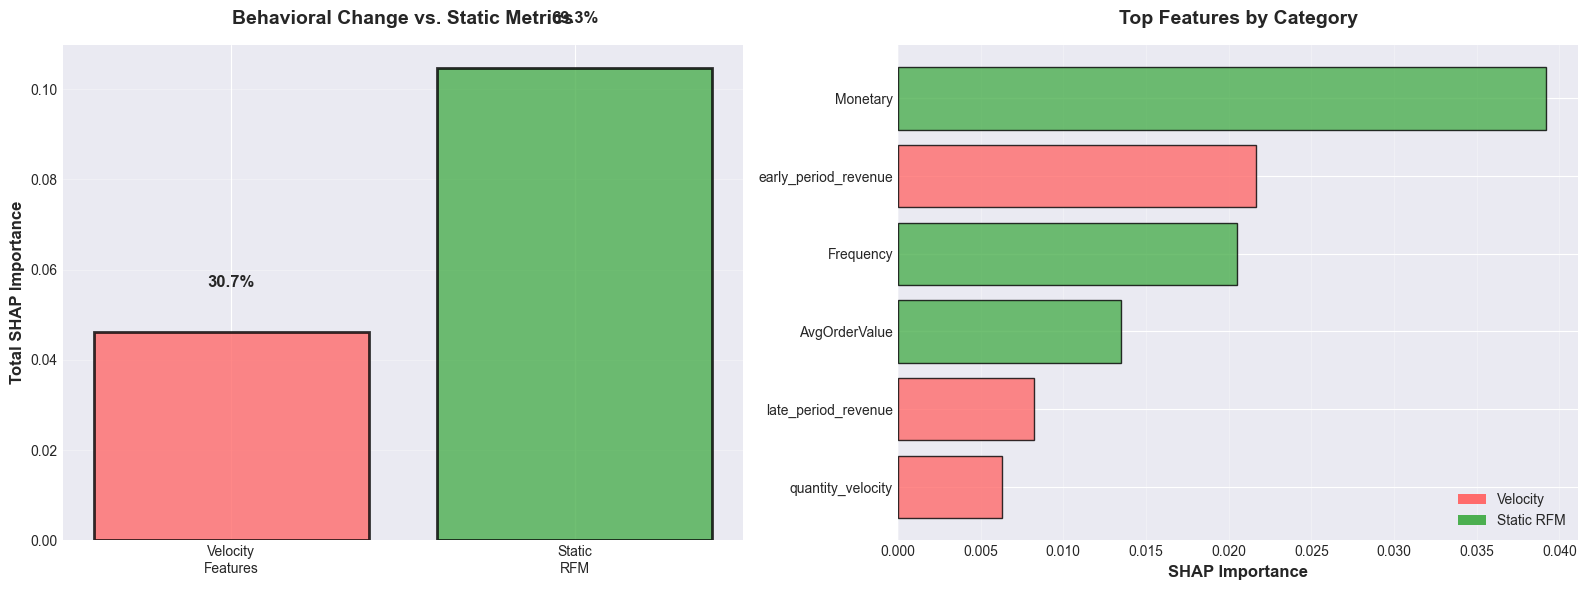


💡 INSIGHT:
   Historical RFM remains strongest predictor.
   → Focus on customers with poor baseline metrics


In [15]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize Velocity vs. Static Impact                      │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category comparison
categories = ['Velocity\nFeatures', 'Static\nRFM']
importances = [velocity_importance, static_importance]
colors = ['#FF6B6B', '#4CAF50']

axes[0].bar(categories, importances, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Total SHAP Importance', fontsize=12, fontweight='bold')
axes[0].set_title('Behavioral Change vs. Static Metrics', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)

# Add percentages
for i, v in enumerate(importances):
    pct = v/(velocity_importance+static_importance)*100
    axes[0].text(i, v + 0.01, f'{pct:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Top features from each category
velocity_top = shap_importance[shap_importance['feature'].isin(velocity_features)].head(3)
static_top = shap_importance[shap_importance['feature'].isin(static_rfm)].head(3)

combined = pd.concat([velocity_top, static_top]).sort_values('importance', ascending=True)
feature_colors = ['#FF6B6B' if f in velocity_features else '#4CAF50' for f in combined['feature']]

axes[1].barh(range(len(combined)), combined['importance'], color=feature_colors, alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(combined)))
axes[1].set_yticklabels(combined['feature'])
axes[1].set_xlabel('SHAP Importance', fontsize=12, fontweight='bold')
axes[1].set_title('Top Features by Category', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', label='Velocity'),
    Patch(facecolor='#4CAF50', label='Static RFM')
]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(DIR_FIGURES / '27_velocity_vs_static.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT:")
if velocity_importance > static_importance:
    print("   Behavioral CHANGE is more predictive than historical values.")
    print("   → Focus interventions on declining engagement patterns")
else:
    print("   Historical RFM remains strongest predictor.")
    print("   → Focus on customers with poor baseline metrics")

---

## 5. High-Value Customer Risk Analysis

╔════════════════════════════════════════════════════════════════╗
║              HIGH-VALUE CUSTOMER CHURN DRIVERS                  ║
╚════════════════════════════════════════════════════════════════╝

### Focus:
Why are our **most valuable customers** at risk?

In [16]:
# ┌────────────────────────────────────────────────────────────┐
# │ Define High-Value Customers                               │
# └────────────────────────────────────────────────────────────┘

# Top 25% by predicted CLV
clv_threshold = analysis_df['CLV_365d'].quantile(0.75)
analysis_df['high_value'] = (analysis_df['CLV_365d'] >= clv_threshold).astype(int)

print("High-Value Customer Definition:")
print("="*80)
print(f"CLV Threshold (75th percentile): £{clv_threshold:,.2f}")
print(f"High-Value Customers: {analysis_df['high_value'].sum()} ({analysis_df['high_value'].sum()/len(analysis_df)*100:.1f}%)")

# High-value churn rate
high_value_df = analysis_df[analysis_df['high_value'] == 1]
hv_churn_rate = high_value_df['churned'].mean()
overall_churn_rate = analysis_df['churned'].mean()

print(f"\nChurn Rates:")
print(f"  High-Value: {hv_churn_rate*100:.1f}%")
print(f"  Overall: {overall_churn_rate*100:.1f}%")
print(f"  Difference: {(hv_churn_rate - overall_churn_rate)*100:+.1f} percentage points")

High-Value Customer Definition:
CLV Threshold (75th percentile): £3,574.74
High-Value Customers: 206 (25.3%)

Churn Rates:
  High-Value: 13.1%
  Overall: 26.9%
  Difference: -13.8 percentage points
